<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

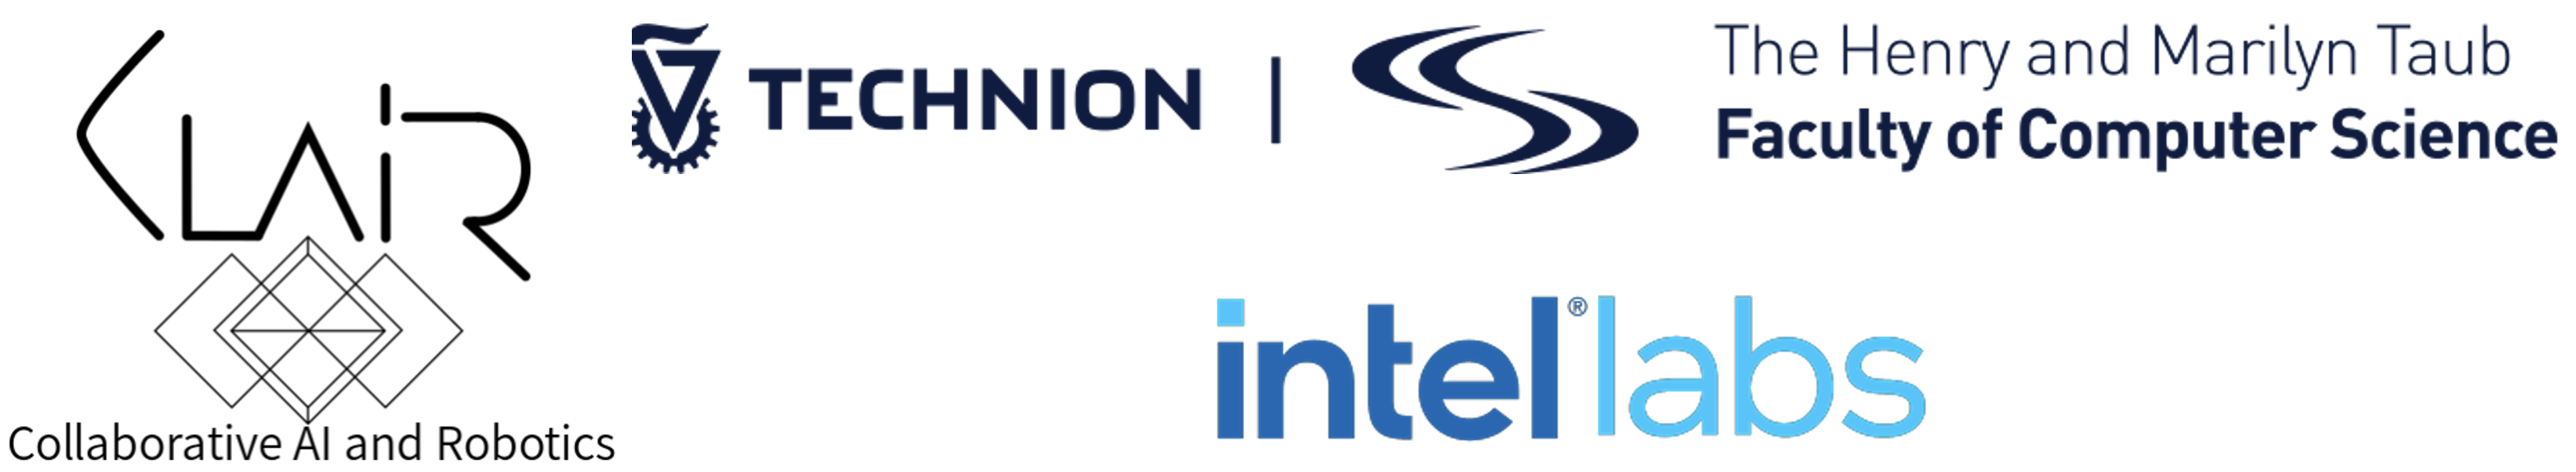

#### Yuval Goshen, Guy Azran, Sarah Keren

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

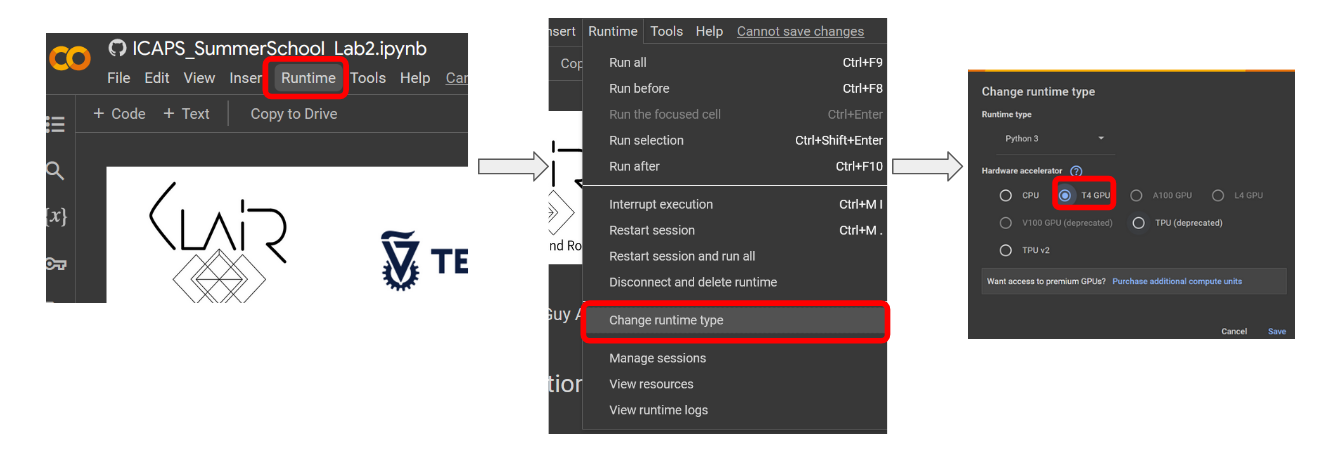

When you fill code in cells for tasks, make sure you delete the

    %%script true

at the beginning. This line prevents cells from running before you fill them.

# Integrating Task and Motion Planning (cont.)

In the previous tutorial, we demonstrated the difficulties of bridging between the abstract world of task planning and the continuous world of motion planning. Our main goal was to be able to run a plan of PDDL actions and execute them with our robot. We called this "Task **_THEN_** Motion Planning" and showed that, even in a simulated environment, there are many issues to consider and overcome.

So are we done yet? Not a chance! The word "then" is emphasized because we are only performing our integration in a single direction (task planning --> motion planning). However, the truly interesting issues arise when attempting to integrate in both directions.

### Setup

#### Required Tutorial Packages

In [ ]:
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/ICAPS-24"

#### MuJoCo Render Speed-up with GPU

**CHANGE TO GPU RUNTIME FOR FASTER RENDERING**

In [ ]:
import os
import subprocess
from sys import stderr

try:
  is_gpu = not bool(subprocess.run('nvidia-smi').returncode)
except FileNotFoundError as e:
  is_gpu = False
if is_gpu:
  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
else:
  print(
    'Cannot communicate with GPU.\n'
    'Make sure you are using a GPU Colab runtime.\n'
    'Go to the Runtime menu and select Choose runtime type.\n'
    'You can also skip this and use CPU with slower rendering.',
    file=stderr)

#### Set OpenGL Rendering

**SKIP THIS CELL IF RUNNING ON APPLE SILICON**

In [ ]:
%env MUJOCO_GL=egl

#### Video Display Utilities

In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

## Task **_AND_** Motion Planning

Hitherto, we expected the motion plan to simply work. We found a single high-level plan and let the skill executor take it from there. Task _then_ motion planning means we trust the motion planner to execute the plan to perfection. But is this a realistic expectation? Of course not! We saw several examples where the motion planner fails. We also implemented **dynamic replanning** which would replan every time an unexpected state was reached. But dynamic replanning is just multiple iterations of task _then_ motion planning. To proudly call our pipeline "task **_AND_** motion planning", we must face the true TAMP demons, and there are many.

So what have we not considered yet? So far we've addressed the limitations of the motion planner in understanding the task planner. to complete integration, we must make the task planner understand the motion planner.

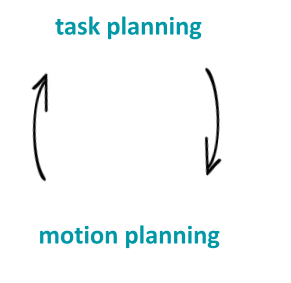

#### ❓Question 1

What scenarios can you think of that will require the task and motion planners to work together in order to complete the task? List as many as you can.

_YOUR ANSWER HERE_

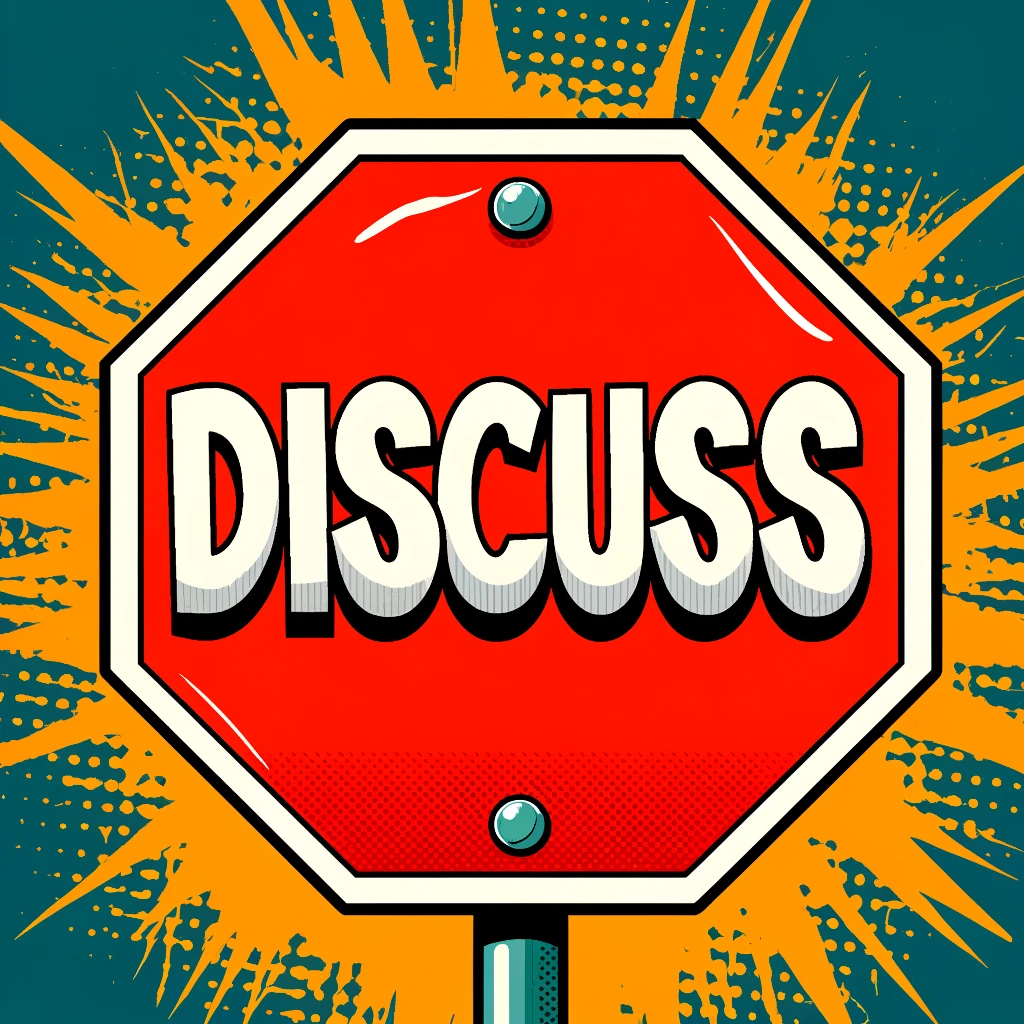

## The Task Planner Does Not Understand Physical Motion

The task planner does not take into consideration anything outside of the PDDL abstraction and the PDDL abstraction does not fully capture the model of the real world. We will use our NTBW domain as an example:

In [ ]:
DOMAIN = """
(define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t -table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c -color)
 )

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty))
	     :effect
	     (and (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b)))

  (:action put-down
	     :parameters (?b - block ?t - table)
	     :precondition (holding ?b)
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)))

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)))

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2)))))
"""

We will show two interesting cases where our PDDL representation is not rich enough to capture important aspects required for completing the task.

### Constrained by Geometry

The task planner is unaware of the geometry in the environment. This can come into play in multiple ways. For example:
1. What if there is no more room on the table to add a new block? Our PDDL representation assumes there is enough room for as many blocks as we want on each table. It does not consider that the table has a limited size.

2. What if the only place left to put down a block is too far for the robot to reach? The task planner does not know the robot's workspace.

3. What if there _is_ enough room on the table but the blocks are not arranged to allow this?

Below is a depiction of (3). As we can see, blocks B2-B10 are on table T2, and we need to move block B1 from table T3 to table T2. However, the blocks are arranged in such a way that we cannot find a free spot on table T2 that won't lead to block collision. A possible solution is to move block 5 up a little to make room for block B1.

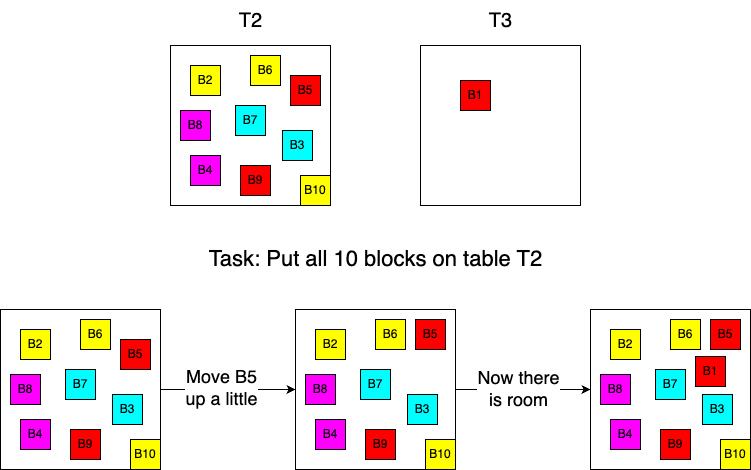

#### ❓Question 2

What are possible solutions to overcome scenarios (1) and (2)? Note that this does not necessarily require communication between the task and motion planners.

_YOUR ANSWER HERE_

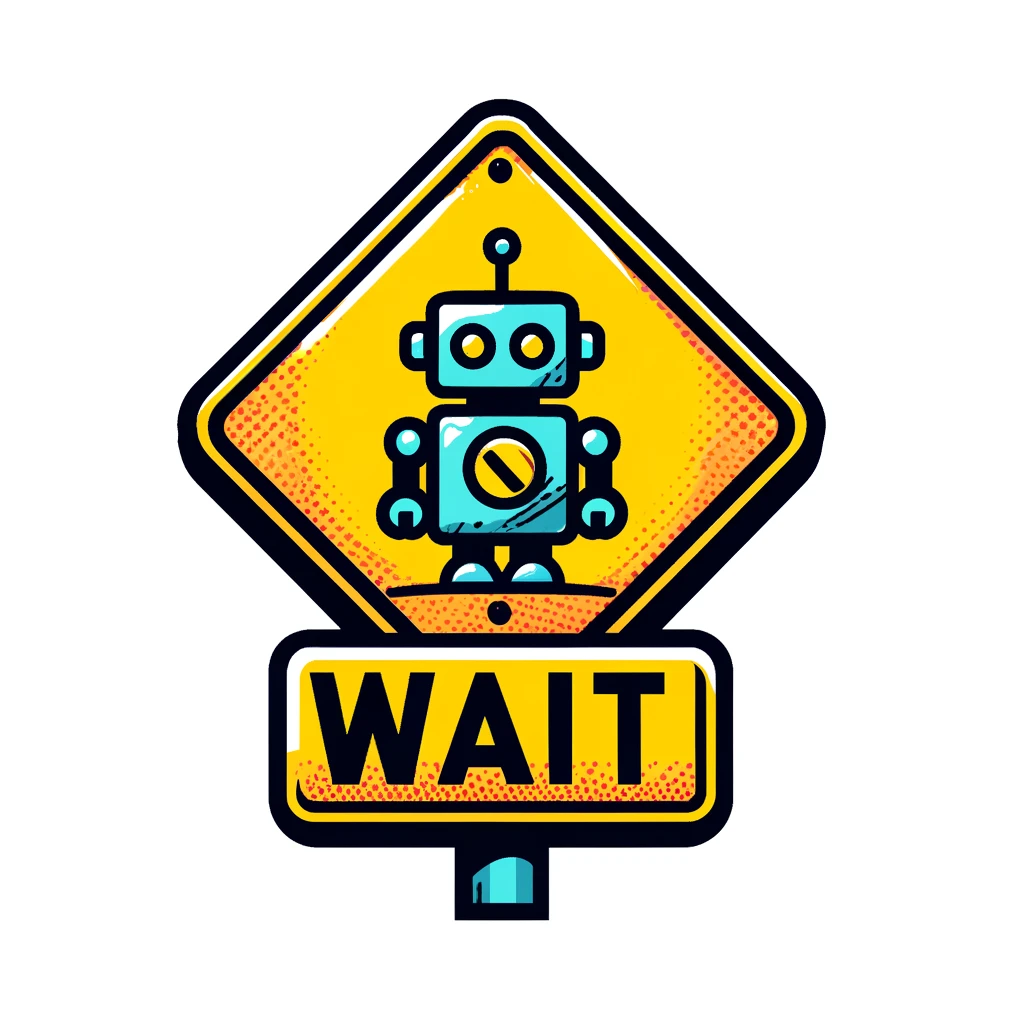

Let's define a problem that translates to scenario (1), i.e., there is no room on the table in the real world.

In [ ]:
PROBLEM = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 B6 B7 B8 B9 B10 - block
R Y C P - color
T1 T2 T3  - table
)
(:init
(handempty)

(ontable B1 T3)
(clear B1)
(bcolor B1 R)

(ontable B2 T2)
(clear B2)
(bcolor B2 Y)

(ontable B3 T2)
(clear B3)
(bcolor B3 C)

(ontable B4 T2)
(clear B4)
(bcolor B4 P)

(ontable B5 T2)
(clear B5)
(bcolor B5 R)

(ontable B6 T2)
(clear B6)
(bcolor B6 Y)

(ontable B7 T2)
(clear B7)
(bcolor B7 C)

(ontable B8 T2)
(clear B8)
(bcolor B8 P)

(ontable B9 T2)
(clear B9)
(bcolor B9 R)

(ontable B10 T2)
(clear B10)
(bcolor B10 Y)

)
(:goal (and
(ontable B1 T2)
))
)
"""

from aidm.environments.pddl.pddl_env import PDDLProblem
problem = PDDLProblem(DOMAIN, PROBLEM)

In this problem, blocks B2-B10 are on table T2 and block B1 sits alone on table T3. An instantiation of this NTBW problem in MuJoCo is initialized below.

In [ ]:
from n_table_blocks_world.n_table_block_world_special import NTableBlocksWorldFullTable
import mediapy as media

env = NTableBlocksWorldFullTable(render_mode='rgb_array')
state = env.reset()
frame = env.render()
media.show_image(frame)

Let's see what happens when we try to solve this problem using our trusty TAMP executer from the previous tutorial. First, we bring back our predicates and state estimator function from the previous tutorial.

In [ ]:
from tamp_helpers.pddl_to_mujoco import (
  OBJECT_PDDL_ID_TO_MUJOCO_NAME,
  TABLE_PDDL_IDS,
  BLOCK_PDDL_IDS,
  COLOR_PDDL_ID_TO_RGBA_VALUE_IN_MUJOCO,
  pddl_id_to_mujoco_name,
  pddl_id_to_mujoco_entity
)

from tamp_helpers.pred_utils import entity_is_on_entity

import numpy as np

def holding(block_id, state):
  block_name = pddl_id_to_mujoco_name(block_id)
  return state['grasped_object'] == block_name

def on(block1_id, block2_id, state):
  if holding(block1_id, state):
    return False

  block1 = pddl_id_to_mujoco_entity(block1_id, env)
  block2 = pddl_id_to_mujoco_entity(block2_id, env)

  return entity_is_on_entity(block1, block2, state)

def ontable(block_id, table_id, state):
  if holding(block_id, state):
    return False

  block = pddl_id_to_mujoco_entity(block_id, env)
  table = pddl_id_to_mujoco_entity(table_id, env)

  return entity_is_on_entity(block, table, state)

def clear(block_id, state):
  return not holding(block_id, state) and not any(
      on(other_block_id, block_id, state)
      for other_block_id in BLOCK_PDDL_IDS
  )

def handempty(state):
  return not any(
      holding(block_id, state)
      for block_id in BLOCK_PDDL_IDS
  )

def bcolor(block_id, color_id, state):
  # NOTE: we do not use the state here because color is static
  block = pddl_id_to_mujoco_entity(block_id, env)
  return np.all(block.rgba == COLOR_PDDL_ID_TO_RGBA_VALUE_IN_MUJOCO[color_id.lower()])

In [ ]:
from pddlgymnasium.structs import State as PDDLState


class NTableBlocksWorldStateEstimator:
  def __init__(self, pddl_problem):
    self.all_ground_literals = pddl_problem.env.observation_space.all_ground_literals(pddl_problem.env.get_state())
    self.objects = frozenset(pddl_problem.env._problem.objects)
    self.goal = pddl_problem.env._problem.goal

  def __call__(self, state):
    ground_literals = set()
    for lit in self.all_ground_literals:
      pred_fn = eval(lit.predicate.name)
      vars = list(map(lambda v: v.name, lit.variables))
      if pred_fn(*vars, state):
        ground_literals.add(lit)

    return PDDLState(
        frozenset(ground_literals),
        self.objects,
        self.goal
    )

estimator = NTableBlocksWorldStateEstimator(problem)

We now try to solve the task using our executer. For convenience, we use an identical implementation of the executer hidden in our internal code library.

In [ ]:
from aidm.search.best_first_search import weighted_a_star
from tamp_helpers.executers import execute_tamp_with_replanning, SkillExecuter
import sys

import random
def set_random_seed(seed):
  random.seed(seed)
  np.random.seed(seed)

def your_heuristic(node, problem):
    #get current state literals
    current_state_literals = node.state.content.literals
    #get goal literals
    goal_state_literals = problem.env.problems[0].goal.literals
    #check difference
    count = len(goal_state_literals)
    for literal in goal_state_literals:
        if literal in  current_state_literals:
            count -=1
    return count

def your_solver(problem):
    # using weighted A* with a large weight.
    # adding an iteration limit so that it will not run forever
    return weighted_a_star(problem=problem, heuristic_func=your_heuristic, weight=3, use_closed_list=True, iter_limit=2000)[0]


set_random_seed(42)

executer = SkillExecuter(env)

# we expect this to fail. wrap with try-except block
try:
    suc, frames = execute_tamp_with_replanning(env, problem, your_solver, estimator, executer)
except TimeoutError as e:
    print(e.args[0], file=sys.stderr)

Execution failed with the following error:
```
Could not find a collision-free space on table t2 after 1000 attempts
```
This is not surprising. Since there is not enough room for block B1 on table T2, our sampler could not find a free spot on the table within its attempt limit and raised an exception. The task planner is unaware of this constraint because it is not represented in our PDDL domain.



In **❓Question 2** we were forced to think of creative solutions to this problem. We will now implement such a solution by communicating information about the real world from the motion planner to the task planner. As a first step, we will update our PDDL domain with the `hasroom` predicate which determines whether a table has room to accept a new block.

#### ⚒ Task 1 - ADD THE `hasroom` PREDICATE TO THE DOMAIN AND PROBLEM

`hasroom` is a predicate that accepts a single table as an argument. A block can only be put down on a table if `hasroom` holds for that table. `hasroom` must hold true for a any table immediately after a block on that table has been picked up. Upon initialization, we assume that `hasroom` holds for all tables.

Add the `hasroom` predicate to the domain and problem files below.

In [ ]:
DOMAIN_WITH_HASROOM = """
(define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t -table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c -color)
 )

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty))
	     :effect
	     (and (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b)))

  (:action put-down
	     :parameters (?b - block ?t - table)
	     :precondition (holding ?b)
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)))

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)))

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2)))))
"""

In [ ]:
PROBLEM_WITH_HASROOM = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 B6 B7 B8 B9 B10 - block
R Y C P - color
T1 T2 T3  - table
)
(:init
(handempty)

(ontable B1 T3)
(clear B1)
(bcolor B1 R)

(ontable B2 T2)
(clear B2)
(bcolor B2 Y)

(ontable B3 T2)
(clear B3)
(bcolor B3 C)

(ontable B4 T2)
(clear B4)
(bcolor B4 P)

(ontable B5 T2)
(clear B5)
(bcolor B5 R)

(ontable B6 T2)
(clear B6)
(bcolor B6 Y)

(ontable B7 T2)
(clear B7)
(bcolor B7 C)

(ontable B8 T2)
(clear B8)
(bcolor B8 P)

(ontable B9 T2)
(clear B9)
(bcolor B9 R)

(ontable B10 T2)
(clear B10)
(bcolor B10 Y)

)
(:goal (and
(ontable B1 T2)
))
)
"""

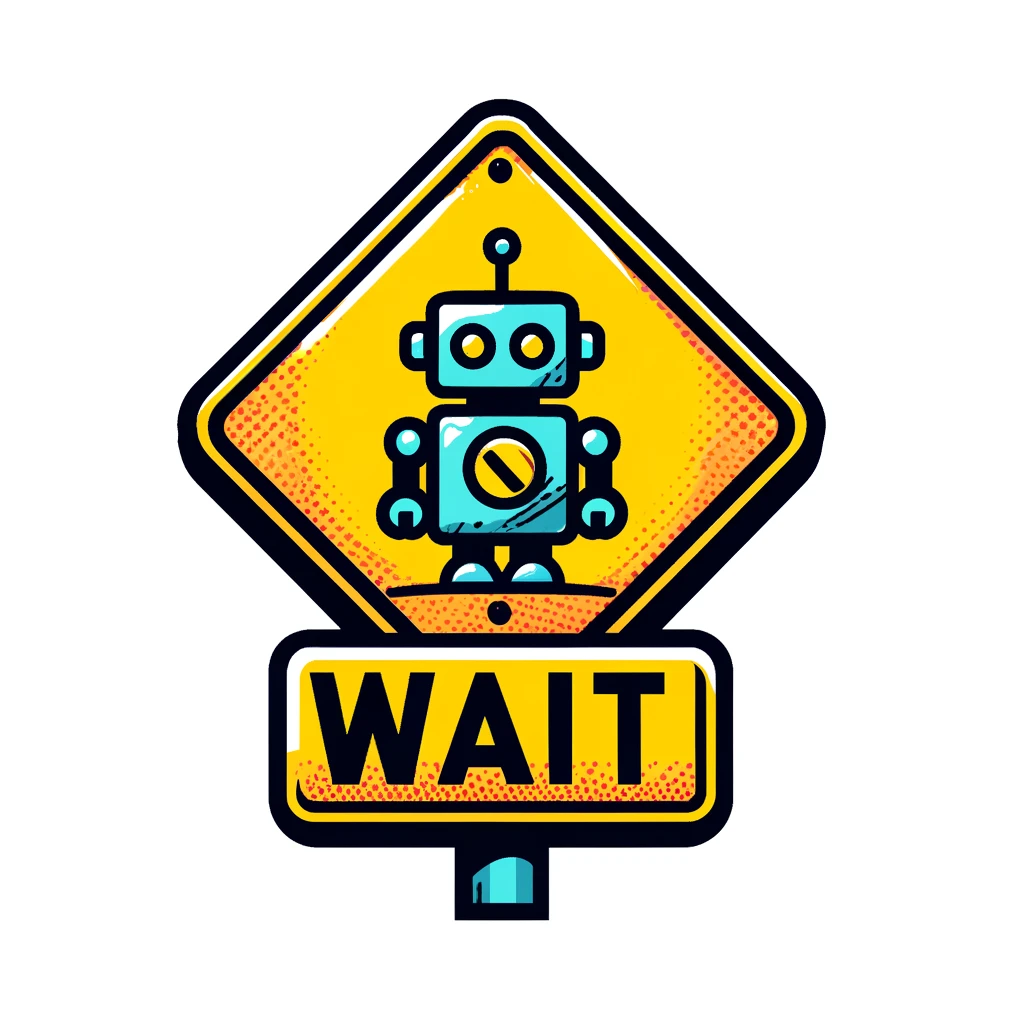

#### Solution

In [ ]:
DOMAIN_WITH_HASROOM = """
(define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t -table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c -color)
               (hasroom ?t - table)
 )

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty))
	     :effect
	     (and (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b)
           (hasroom ?t)))

  (:action put-down
	     :parameters (?b - block ?t - table)
	     :precondition (and (holding ?b) (hasroom ?t))
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)))

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)))

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2)))))
"""

In [ ]:
PROBLEM_WITH_HASROOM = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 B6 B7 B8 B9 B10 - block
R Y C P - color
T1 T2 T3  - table
)
(:init
(handempty)

(hasroom T1)
(hasroom T2)
(hasroom T3)

(ontable B1 T3)
(clear B1)
(bcolor B1 R)

(ontable B2 T2)
(clear B2)
(bcolor B2 Y)

(ontable B3 T2)
(clear B3)
(bcolor B3 C)

(ontable B4 T2)
(clear B4)
(bcolor B4 P)

(ontable B5 T2)
(clear B5)
(bcolor B5 R)

(ontable B6 T2)
(clear B6)
(bcolor B6 Y)

(ontable B7 T2)
(clear B7)
(bcolor B7 C)

(ontable B8 T2)
(clear B8)
(bcolor B8 P)

(ontable B9 T2)
(clear B9)
(bcolor B9 R)

(ontable B10 T2)
(clear B10)
(bcolor B10 Y)

)
(:goal (and
(ontable B1 T2)
))
)
"""

#### ❓Question 3

Is adding the hasroom predicate to the task plan enough ? What else needs to be done?

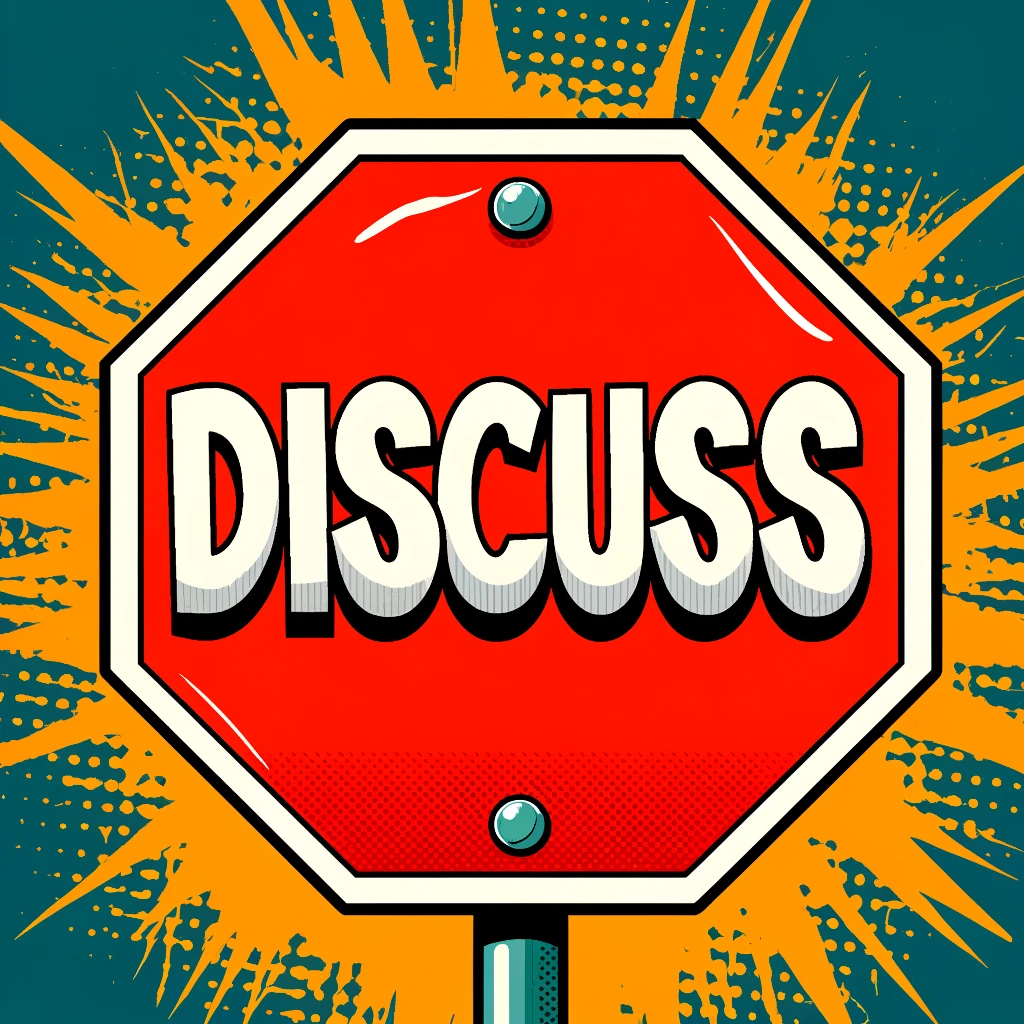

# Adding `hasroom` to the State Estimation

Let's initialize the problem and a new state estimator for that problem.

In [ ]:
problem_with_hasroom = PDDLProblem(DOMAIN_WITH_HASROOM, PROBLEM_WITH_HASROOM)
estimator_with_hasroom = NTableBlocksWorldStateEstimator(problem_with_hasroom)

As with the other predicates, we now must implement `hasroom`. Seeing as our `put_down` skill strongly depends on our ability to sample a free spot on the table, we will use our function for sampling a spot on the table to determine whether there is room for a new block. We will attempt to sample a spot on the table a limited number of times. If a position is found, we know there is room on the table. otherwise, a `TimeoutError` will be raised, indicating that there is (likely) no room on the table.

In [ ]:
from tamp_helpers.table_sampling import sample_free_spot_on_table_for_block

def hasroom(table_id, state, max_attempts=1_000):
  try:
    # sample a spot for any block (B1 in this case) and also check if that block collides with the sampled spot
    sample_free_spot_on_table_for_block(table_id, 'B1', env, max_attempts=max_attempts, skip_self=False)
  except TimeoutError:
    return False

  return True

**NOTE:** We do not need to inform the state estimator of this new predicate thanks to some python trickery 🐍😁. Check out the `eval` built-in function in the [official python documentation](https://docs.python.org/3/library/functions.html).

# Using `hasroom` for planning - will this be enough ?

We will now attempt to solve the problem with our dynamic replanning pipeline. In the initial state, i.e., when we call the state estimator for the first time, it reveals that some table has no room, and will trigger a replan since all tables are supposed to have room in the initial state.

After we update the state, it is not possible to put down a block on the table that is full. If the goal specification requires putting a block on that table, the task plan will dictate that we must first pick up some block from that table, thus freeing up space and allowing us to place the desired block on that table.


Let's see this in action.

In [ ]:
set_random_seed(84)  # change seed to 42 to see alternative ways for making space on the table

suc, frames = execute_tamp_with_replanning(env, problem_with_hasroom, your_solver, estimator_with_hasroom, executer)
media.show_video(frames, fps=8)

Woohoo! We are able to pass information about the physical world from the motion planner (more specifically the table position sampler) to the task planner.

#### ❓Question 4

Assuming the motion planner performs all high-level actions perfectly (as expected by you, the human), how can a dynamic planner fail to solve this problem? What are aspects that are not covered with the current representation? What can be done to fix that? Does it make sense to fix the representation?

_YOUR ANSWER HERE_

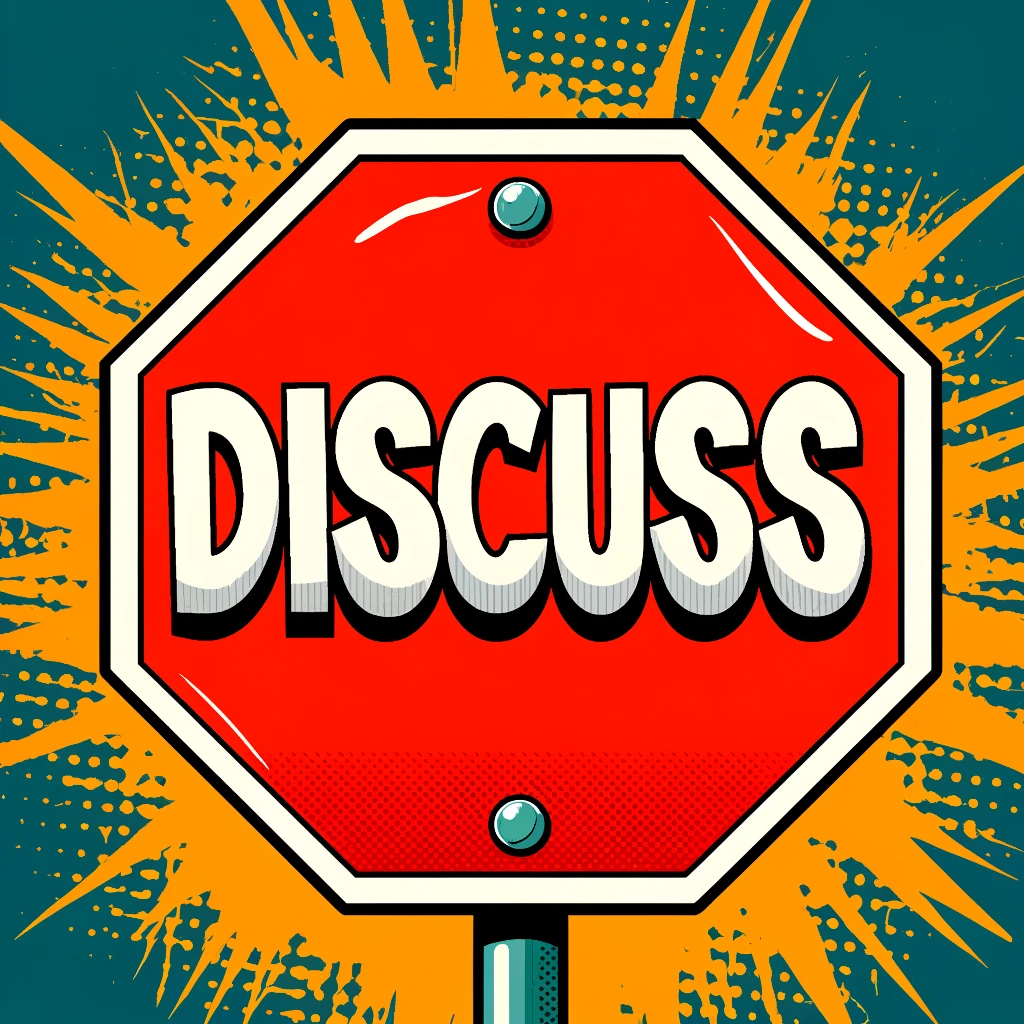

Note that with our solution above, we heavily relied on the ability to replan: while we did use the task plan to update the hasroom value when a block is picked up, we did not capture the other way - the task planner does not know when a table becomes full, and might generate plans that are doomed to fail (and thus require replanning).
This reliance on the ability to replan is not wrong - it is up to the designer to decide what level of granularity and complexity to capture with the task plan, and what to leave to the online executor to resolve via replanning.

If you want to read a great paper about this tradeoff - have a look at the paper **`Hierarchical Task and Motion Planning in the Now`** by Leslie Pack Kaelbling and Tomas Lozano-Perez.

# Reasoning About The Cost of Moving

Recall the extended problem in [tutorial 1](https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab1.ipynb). In this problem, a goal is defined using the blocks' colors instead of direct ID. In this case, the agent must make the choice of which of the blocks of the specified color should be acted upon. The image below depicts such a scenario.

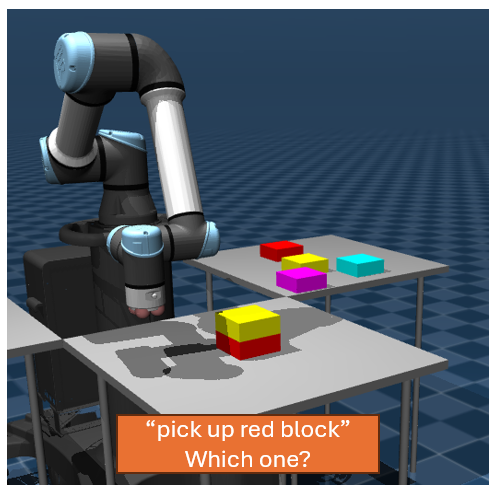

In this example, the robot gripper is close to the red block, but it is under a yellow block. Additionally, there is another red block that is clear for pickup, but is farther away. Which red block should the robot pick up?

Our PDDL representation, which assumes a uniform cost of 1 for all actions, leads us to believe that picking up the farther block is better since picking up the closer block requires first unstacking the yellow block, then setting it down, and only then picking up the newly exposed red block. But is this really the more efficient solution?

#### ❓Question 5

How can we change the PDDL representation to account for the costs of the motions required to pick up any block from the robot's current configuration? How can we do this without changing the PDDL representation? What is the best way?

_YOUR ANSWER HERE_

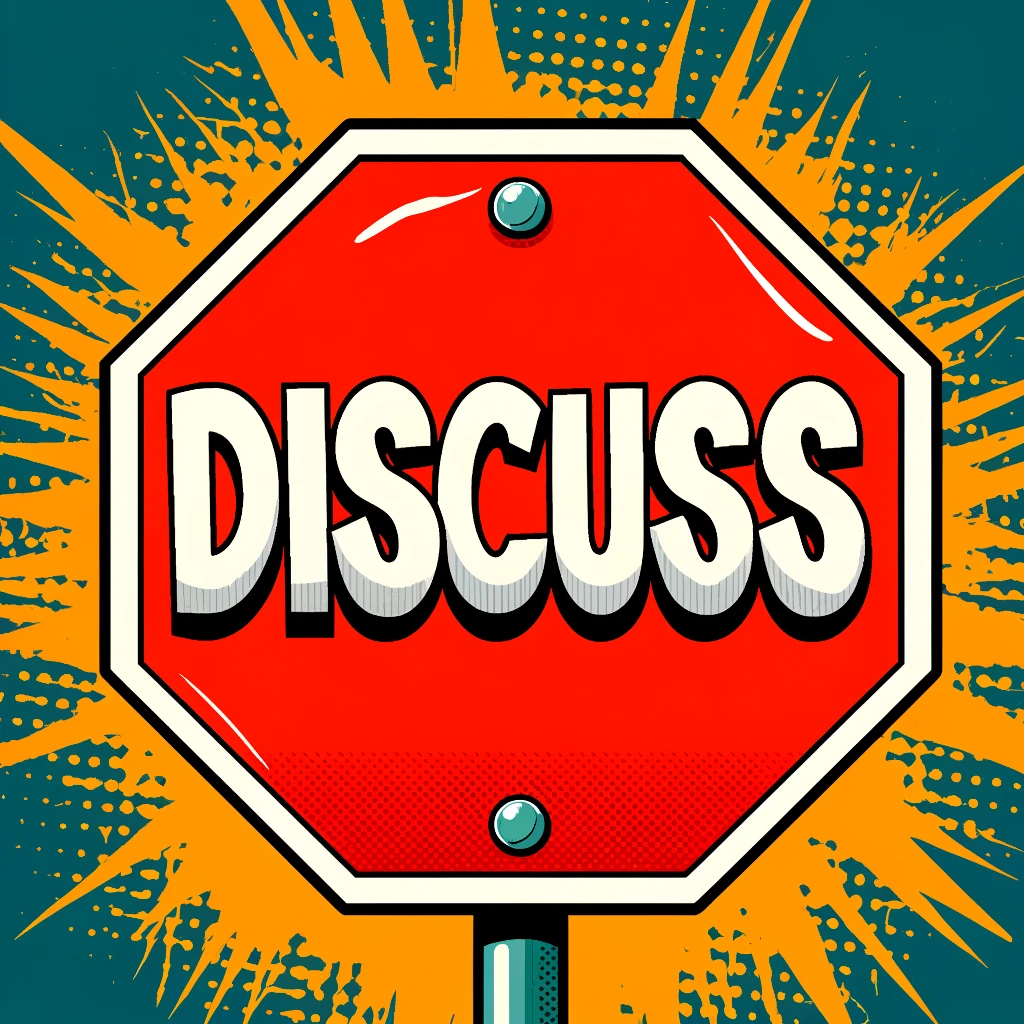

Unless the motion planner plans identical motions for every high-level action, then no static cost defined in PDDL will be able to truly capture the cost of the motions being performed. Furthermore, why should we have to determine the correct costs ourselves? Instead, we will use the motion planner to provide a motion plan for each high-level action. We will measure the effort required to perform these motions and use these as our cost.

First, let's create an environment of the scenario described above.

In [ ]:
from n_table_blocks_world.n_table_block_world_special import NTableBlocksWorldStartNearTable2

env2 = NTableBlocksWorldStartNearTable2(render_mode="rgb_array")
media.show_image(env2.render())

For the sake of this tutorial, we will be measuring effort via the sum of distances between the configurations in the motion plan. Of course, this approach abstracts a lot of information, but it is a heuristic estimation that is relatively easy to compute.

For convenience, we will implement all of this in class `SkillCostEstimator`. This is fairly similar to the `SkillExecuter`, but instead of performing the motions it makes a plan and computes the cost of those motions.

#### ⚒ Task 2 - COMPLETE THE `estimate_motion_to_pose_cost` FUNCTION IMPLEMENTATION

We have already calculated a configuration path using the motion planner. Your task is to determine the length (i.e. the cost) of this plan, measured in the sum of distances between successor configurations in the path.

In [ ]:
facing_down_R = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])

class SkillCostEstimator:
    def __init__(self, env, motion_planner):
        self.env = env
        self.motion_planner = motion_planner

    def estimate_motion_to_pose_cost(self, target_position, target_orientation=facing_down_R):
        joint_state = self.env.robot_joint_pos
        path = self.motion_planner.plan_from_config_to_pose(joint_state,
                                                            target_position,
                                                            target_orientation)

        # YOUR CODE HERE: compute path length
        path_length = ...
        return path_length

    def pick_up(self, block_id, table_id):
        block_name = pddl_id_to_mujoco_name(block_id)
        block_position = self.env.get_object_pos(block_name)
        target_position = block_position + np.array([0, 0, 0.1])

        return self.estimate_motion_to_pose_cost(target_position)

    def put_down(self, block_id, table_id):
        free_spot = sample_free_spot_on_table_for_block(table_id, block_id, self.env)
        free_spot += np.array([0, 0, 0.1])
        return self.estimate_motion_to_pose_cost(free_spot)

    def stack(self, block1_id, block2_id):
        block2_name = pddl_id_to_mujoco_name(block2_id)
        block2_position = self.env.get_object_pos(block2_name)
        target_position = block2_position + np.array([0, 0, 0.1])

        return self.estimate_motion_to_pose_cost(target_position)

    def unstack(self, block1_id, block2_id):
        return self.estimate_pick_up_cost(block1_id, None)


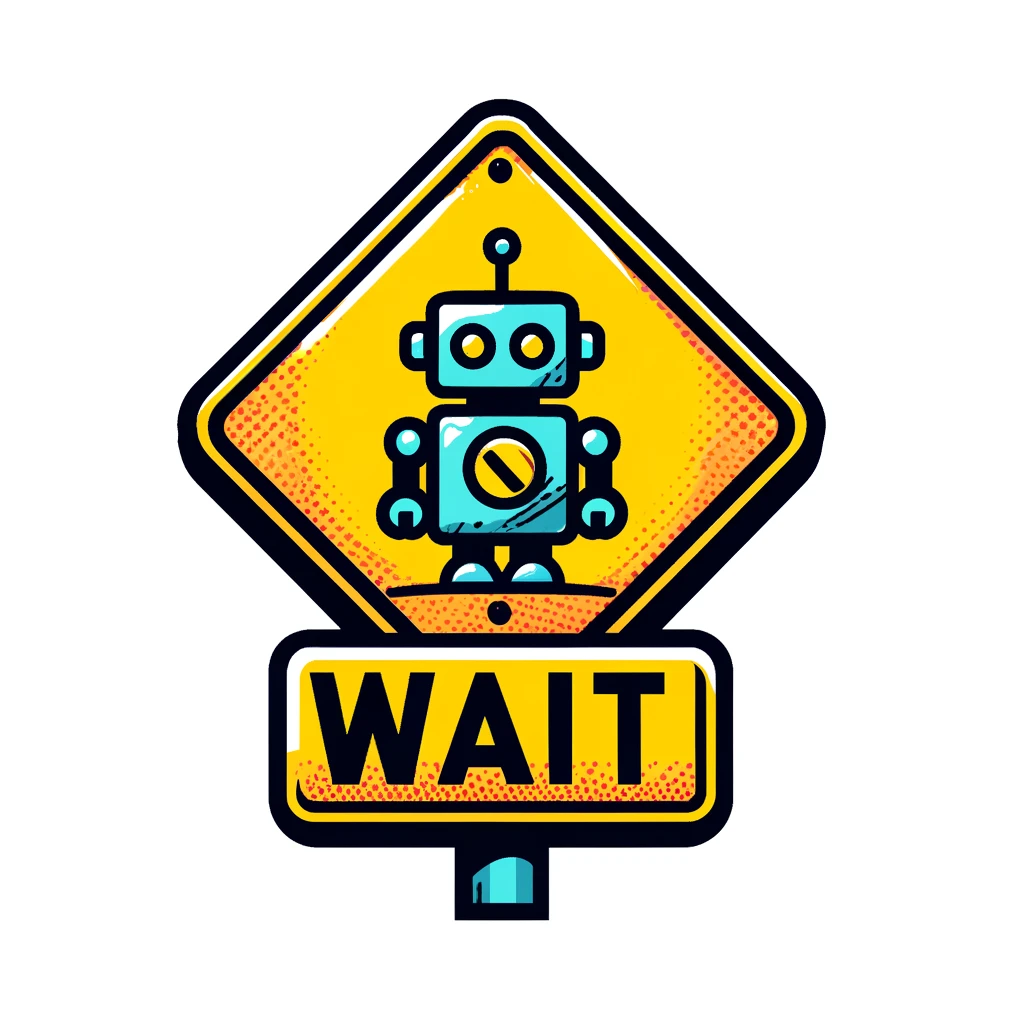

#### Solution

In [ ]:
facing_down_R = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])

class SkillCostEstimator:
    def __init__(self, env, motion_planner):
        self.env = env
        self.motion_planner = motion_planner

    def estimate_motion_to_pose_cost(self, target_position, target_orientation=facing_down_R):
        joint_state = self.env.robot_joint_pos
        path = self.motion_planner.plan_from_config_to_pose(joint_state,
                                                            target_position,
                                                            target_orientation)
        path_distances = [np.linalg.norm(np.array(path[i]) - np.array(path[i+1]))
         for i in range(len(path) - 1)]
        return sum(path_distances)

    def pick_up(self, block_id, table_id):
        block_name = pddl_id_to_mujoco_name(block_id)
        block_position = self.env.get_object_pos(block_name)
        target_position = block_position + np.array([0, 0, 0.1])

        return self.estimate_motion_to_pose_cost(target_position)

    def put_down(self, block_id, table_id):
        free_spot = sample_free_spot_on_table_for_block(table_id, block_id, self.env)
        free_spot += np.array([0, 0, 0.1])
        return self.estimate_motion_to_pose_cost(free_spot)

    def stack(self, block1_id, block2_id):
        block2_name = pddl_id_to_mujoco_name(block2_id)
        block2_position = self.env.get_object_pos(block2_name)
        target_position = block2_position + np.array([0, 0, 0.1])

        return self.estimate_motion_to_pose_cost(target_position)

    def unstack(self, block1_id, block2_id):
        return self.pick_up(block1_id, None)

#### ❓Question 6

Given our `SkillCostEstimator`, which block do you think the robot should pick up to minimize cost and why?

_YOUR ANSWER HERE_

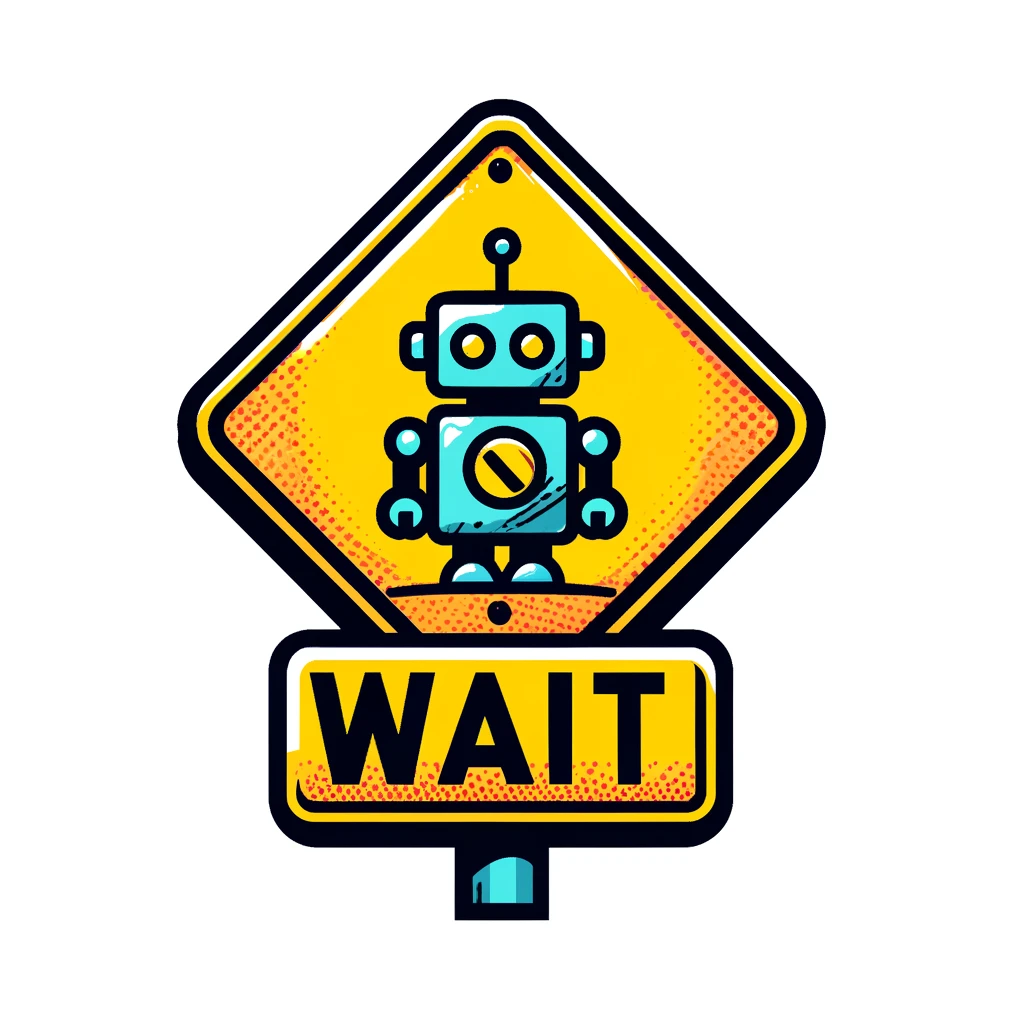

Let's initialize a cost estimator and choose the blocks we wish to act upon.

In [ ]:
from motion_planning.motion_planner import NTableBlocksWorldMotionPlanner

motion_planner = NTableBlocksWorldMotionPlanner(env2)
cost_estimator = SkillCostEstimator(env2, motion_planner)

yellow_block_to_unstack_id = 'B10'
red_block_below_yellow_id = 'B9'
clear_red_block_id = 'B1'

Now we will estimate the cost of picking up the clear red block from the far table. Remember that the motion planner is stochastic and so we should estimate the cost multiple times and aggregate the results.

In [ ]:
set_random_seed(42)
c1 = cost_estimator.pick_up(clear_red_block_id, 'T3')

set_random_seed(84)
c2 = cost_estimator.pick_up(clear_red_block_id, 'T3')

set_random_seed(126)
c3 = cost_estimator.pick_up(clear_red_block_id, 'T3')

print(f'estimation 1: {c1}')
print(f'estimation 2: {c2}')
print(f'estimation 3: {c3}')
print(f'estimated cost of picking up the clear red block from the far table: {sum([c1, c2, c3]) / 3}')

In [ ]:
def estimate_cost_of_picking_close_red_block():
    unstack_cost = cost_estimator.unstack(yellow_block_to_unstack_id, red_block_below_yellow_id)
    put_down_cost = cost_estimator.put_down(yellow_block_to_unstack_id, 'T2')  # put down on the same table for efficency
    pick_up_cost = cost_estimator.pick_up(red_block_below_yellow_id, 'T2')

    return sum([unstack_cost, put_down_cost, pick_up_cost])

set_random_seed(42)
c1 = estimate_cost_of_picking_close_red_block()

set_random_seed(84)
c2 = estimate_cost_of_picking_close_red_block()

set_random_seed(126)
c3 = estimate_cost_of_picking_close_red_block()

print(f'estimation 1: {c1}')
print(f'estimation 2: {c2}')
print(f'estimation 3: {c3}')
print(f'estimated cost of picking up the close red block under the yellow block: {sum([c1, c2, c3]) / 3}')

As we can see, it is less costly to move to the farther table and pick up the block there. We can now incorporate this cost inside our task plan for a more accurate cost estimationon for high-level actions that takes real-world motion into account.

#### ❓Question 7

What are the limitations of the cost estimation method we implemented? Do you have better ideas?

_YOUR ANSWER HERE_

## Other Considerations (that we will not get into)

Of course, in the short time we had together, we only capture a tiny fraction of the complexities that arise when integrating task and motion planning. Other important aspects that should be considered include:

- Partial Observability - how to maintain a state estimation if we have uncertainty regarding the state of the world ?
- Multi-agent - how do we choose high-level actions with multiple robots to avoid colliding?
- Integrating navigation - what if we need to move somewhere before we can perform the high-level action?
- And many more...

# Are we done? Not even close.



With the tutorials we have prepared, we hope that we have exposed you to some of the complexities that arise when attempting to integrate task and motion planning and get our robots to accomplish complex tasks. Our hope is that our joint investigation will lead to novel research ideas and helpful breakthroughs.


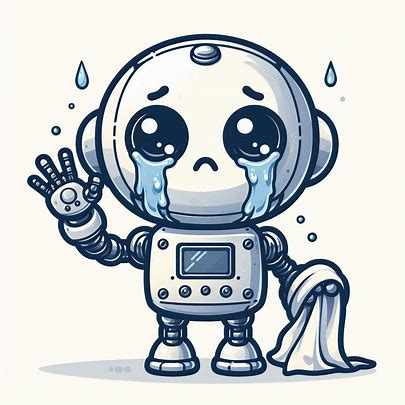